In [34]:
import sqlite3
from sqlite3 import Error
from pathlib import Path
import subprocess
import pandas as pd
from pandas import DataFrame as df
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import sklearn
from sklearn.metrics import silhouette_score

In [2]:
def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
        
    return conn

In [3]:
def get_data(conn, sql):

    try:
        c = conn.cursor()
        c.execute(sql)
        return c.fetchall()
    except Error as e:
        print(e)

In [4]:
get_Purchases = """ SELECT * 
FROM Purchases """

In [5]:
getTables = "SELECT name FROM sqlite_master WHERE type='table';"

In [6]:
Customers_RFM_Query = """
SELECT MemberId, MAX(Date) AS Last_Purchase_Date, COUNT(DISTINCT Date) AS Frequency, COUNT() AS MonetaryValue
FROM Purchases
GROUP BY MemberId """

In [7]:
con = create_connection(r"Grocery_Store")
Customers_RFM_Unscored = pd.read_sql(Customers_RFM_Query, con)
Customers_RFM_Unscored = Customers_RFM_Unscored.set_index("MemberId")
Customers_RFM_Unscored.head(5)

2.6.0


,Last_Purchase_Date,Frequency,MonetaryValue
MemberId,,,
1000,2015-11-25,5,13
1001,2015-05-02,5,12
1002,2015-08-30,4,8
1003,2015-02-10,4,8
1004,2015-12-02,8,21


In [8]:
Customers_RFM_Unscored['Last_Purchase_Date'] = pd.to_datetime(Customers_RFM_Unscored['Last_Purchase_Date'], format= '%Y-%m-%d')
Customers_RFM_Unscored['Last_Purchase_Date'] = Customers_RFM_Unscored['Last_Purchase_Date'].dt.date

In [9]:
last_day = Customers_RFM_Unscored['Last_Purchase_Date'].max() + datetime.timedelta(days=1)
print(last_day)

2015-12-31


In [10]:
Customers_RFM_1 = Customers_RFM_Unscored.copy()
Customers_RFM_1.columns = ['Recency', 'Frequency', 'Monetary']
Customers_RFM_1['Recency'] = (last_day - Customers_RFM_1['Recency']).dt.days
Customers_RFM_1.head(10)

,Recency,Frequency,Monetary
MemberId,,,
1000,36,5,13
1001,243,5,12
1002,123,4,8
1003,324,4,8
1004,29,8,21
1005,707,2,4
1006,200,4,15
1008,89,2,12
1009,87,4,9


In [11]:
Customers_RFM_2 = Customers_RFM_Unscored.copy()
Customers_RFM_2.columns = ['Recency', 'Frequency', 'Monetary']
Customers_RFM_2['Recency'] = 1/(last_day - Customers_RFM_2['Recency']).dt.days
Customers_RFM_2.head(10)

,Recency,Frequency,Monetary
MemberId,,,
1000,0.027778,5,13
1001,0.004115,5,12
1002,0.008130,4,8
1003,0.003086,4,8
1004,0.034483,8,21
1005,0.001414,2,4
1006,0.005000,4,15
1008,0.011236,2,12
1009,0.011494,4,9


Text(0.5, 1.0, 'Histogram of Monetary 2')

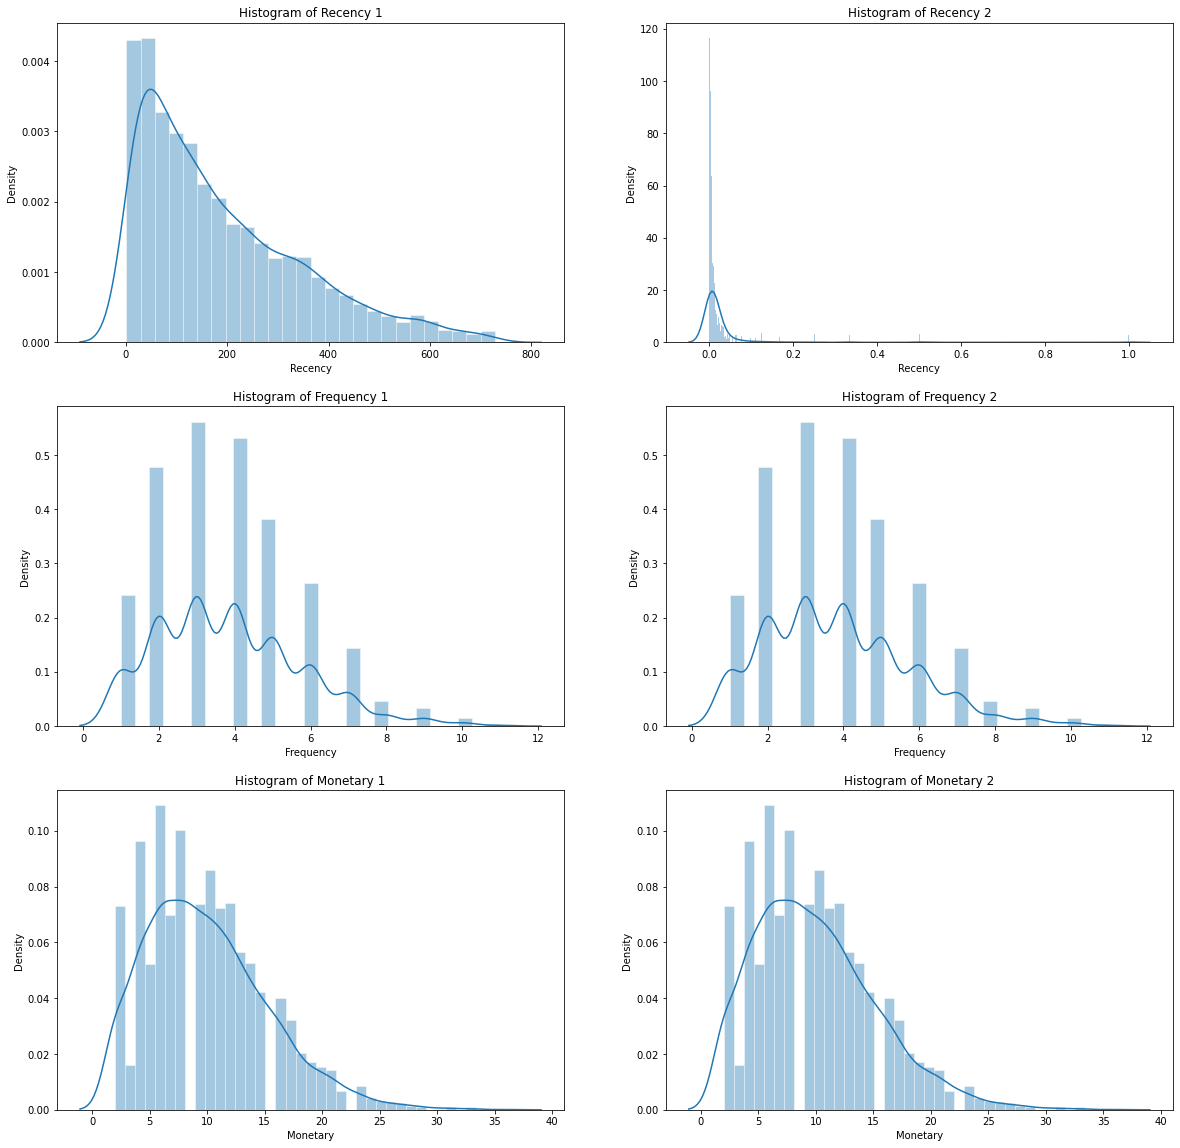

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))

sns.histplot(ax=axes[0,0], data=Customers_RFM_1, x='Recency', kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
axes[0,0].set_title('Histogram of Recency 1')

sns.histplot(ax=axes[0,1], data=Customers_RFM_2, x='Recency', kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
axes[0,1].set_title('Histogram of Recency 2')

sns.histplot(ax=axes[1,0], data=Customers_RFM_1, x='Frequency', kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
axes[1,0].set_title('Histogram of Frequency 1')

sns.histplot(ax=axes[1,1], data=Customers_RFM_2, x='Frequency', kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
axes[1,1].set_title('Histogram of Frequency 2')

sns.histplot(ax=axes[2,0], data=Customers_RFM_1, x='Monetary', kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
axes[2,0].set_title('Histogram of Monetary 1')

sns.histplot(ax=axes[2,1], data=Customers_RFM_2, x='Monetary', kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
axes[2,1].set_title('Histogram of Monetary 2')




In [13]:
customers_RFM_Transformed_1 = pd.DataFrame(index= Customers_RFM_1.index)
customers_RFM_Transformed_1["Recency"] = stats.boxcox(Customers_RFM_1['Recency'])[0]
customers_RFM_Transformed_1["Frequency"] = stats.boxcox(Customers_RFM_1['Frequency'])[0]
customers_RFM_Transformed_1["Monetary"] = stats.boxcox(Customers_RFM_1['Monetary'])[0]
customers_RFM_Transformed_1.tail()


,Recency,Frequency,Monetary
MemberId,,,
4996,7.016236,1.412097,3.847542
4997,1.763905,0.810273,2.654617
4998,9.852175,0.000000,0.802660
4999,2.132343,2.725071,5.191431
5000,17.690836,1.412097,2.988455


In [14]:
customers_RFM_Transformed_2 = pd.DataFrame(index= Customers_RFM_2.index)
customers_RFM_Transformed_2["Recency"] = stats.boxcox(Customers_RFM_2['Recency'])[0]
customers_RFM_Transformed_2["Frequency"] = stats.boxcox(Customers_RFM_2['Frequency'])[0]
customers_RFM_Transformed_2["Monetary"] = stats.boxcox(Customers_RFM_2['Monetary'])[0]
customers_RFM_Transformed_2.tail()

,Recency,Frequency,Monetary
MemberId,,,
4996,-7.016235,1.412097,3.847542
4997,-1.763905,0.810273,2.654617
4998,-9.852175,0.000000,0.802660
4999,-2.132343,2.725071,5.191431
5000,-17.690835,1.412097,2.988455


Text(0.5, 1.0, 'Transformed Monetary 2')

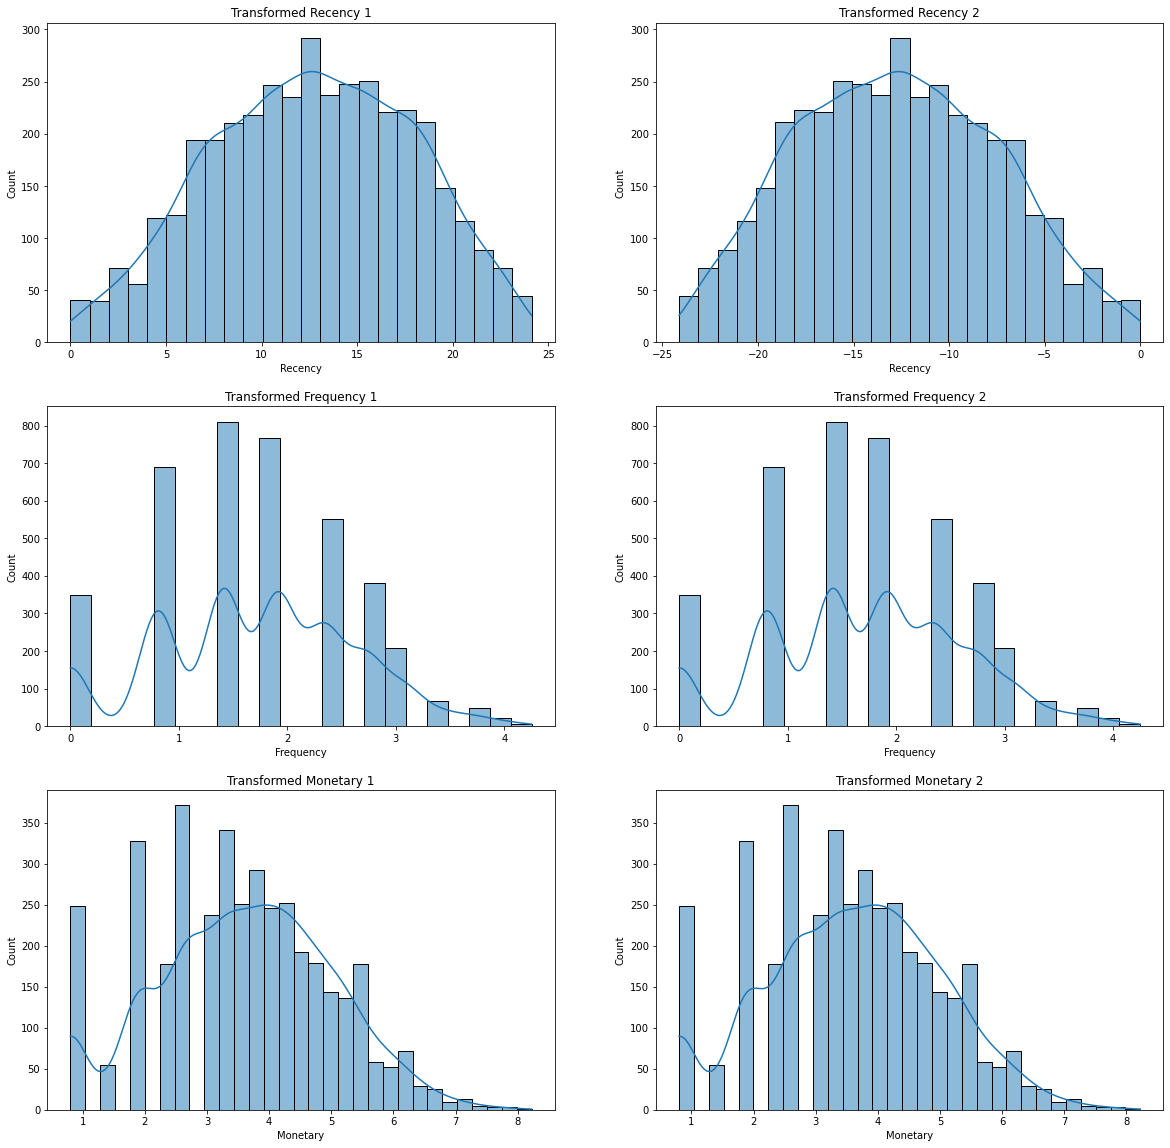

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(20,20))

sns.histplot(ax=ax[0,0], data=customers_RFM_Transformed_1, x='Recency', kde=True)
ax[0,0].set_title('Transformed Recency 1')

sns.histplot(ax=ax[0,1], data=customers_RFM_Transformed_2, x='Recency', kde=True)
ax[0,1].set_title('Transformed Recency 2')

sns.histplot(ax=ax[1,0], data=customers_RFM_Transformed_1, x='Frequency', kde=True)
ax[1,0].set_title('Transformed Frequency 1')

sns.histplot(ax=ax[1,1], data=customers_RFM_Transformed_2, x='Frequency', kde=True)
ax[1,1].set_title('Transformed Frequency 2')

sns.histplot(ax=ax[2,0], data=customers_RFM_Transformed_1, x='Monetary', kde=True)
ax[2,0].set_title('Transformed Monetary 1')

sns.histplot(ax=ax[2,1], data=customers_RFM_Transformed_2, x='Monetary', kde=True)
ax[2,1].set_title('Transformed Monetary 2')

In [16]:
scaler = StandardScaler()

scaler.fit(customers_RFM_Transformed_1)
customers_RFM_Normalised_1 = df(scaler.transform(customers_RFM_Transformed_1), index=customers_RFM_Transformed_1.index, columns=customers_RFM_Transformed_1.columns)
customers_RFM_Normalised_1.head(10)

,Recency,Frequency,Monetary
MemberId,,,
1000,-1.083711,0.700267,0.679759
1001,0.588682,0.700267,0.518780
1002,-0.132977,0.224643,-0.219648
1003,0.946600,0.224643,-0.219648
1004,-1.214202,1.868441,1.764258
1005,2.110171,-0.987600,-1.227829
1006,0.365227,0.224643,0.981175
1008,-0.422372,-0.987600,0.518780
1009,-0.441547,0.224643,-0.017743


In [17]:
print(customers_RFM_Normalised_1.mean(axis = 0))
print(customers_RFM_Normalised_1.std(axis = 0))

Recency      8.817985e-17
Frequency   -3.803041e-16
Monetary     2.227709e-16
dtype: float64
Recency      1.000128
Frequency    1.000128
Monetary     1.000128
dtype: float64


In [18]:
scaler = StandardScaler()

scaler.fit(customers_RFM_Transformed_2)
customers_RFM_Normalised_2 = df(scaler.transform(customers_RFM_Transformed_2), index=customers_RFM_Transformed_2.index, columns=customers_RFM_Transformed_2.columns)
customers_RFM_Normalised_2.head(10)

,Recency,Frequency,Monetary
MemberId,,,
1000,1.083711,0.700267,0.679759
1001,-0.588682,0.700267,0.518780
1002,0.132977,0.224643,-0.219648
1003,-0.946600,0.224643,-0.219648
1004,1.214202,1.868441,1.764258
1005,-2.110171,-0.987600,-1.227829
1006,-0.365227,0.224643,0.981175
1008,0.422372,-0.987600,0.518780
1009,0.441547,0.224643,-0.017743


In [19]:
print(customers_RFM_Normalised_2.mean(axis = 0))
print(customers_RFM_Normalised_2.std(axis = 0))

Recency     -1.712330e-16
Frequency   -3.803041e-16
Monetary     2.227709e-16
dtype: float64
Recency      1.000128
Frequency    1.000128
Monetary     1.000128
dtype: float64


Text(0.5, 1.0, 'Normalized Monetary 2')

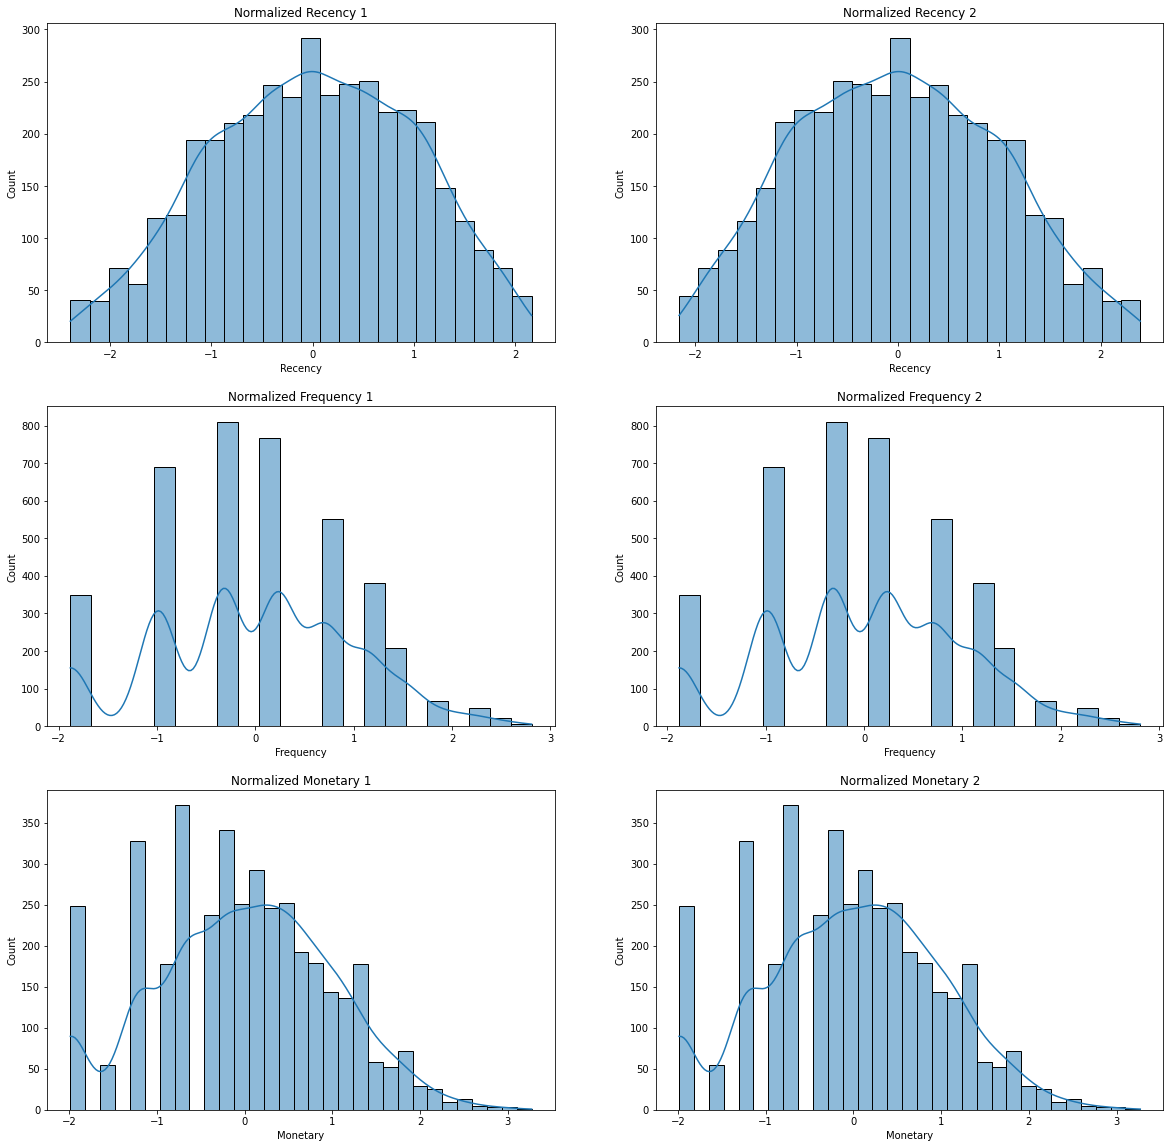

In [20]:
fig, ax = plt.subplots(3, 2, figsize=(20,20))

sns.histplot(ax=ax[0,0], data=customers_RFM_Normalised_1, x='Recency', kde=True)
ax[0,0].set_title('Normalized Recency 1')

sns.histplot(ax=ax[0,1], data=customers_RFM_Normalised_2, x='Recency', kde=True)
ax[0,1].set_title('Normalized Recency 2')

sns.histplot(ax=ax[1,0], data=customers_RFM_Normalised_1, x='Frequency', kde=True)
ax[1,0].set_title('Normalized Frequency 1')

sns.histplot(ax=ax[1,1], data=customers_RFM_Normalised_2, x='Frequency', kde=True)
ax[1,1].set_title('Normalized Frequency 2')

sns.histplot(ax=ax[2,0], data=customers_RFM_Normalised_1, x='Monetary', kde=True)
ax[2,0].set_title('Normalized Monetary 1')

sns.histplot(ax=ax[2,1], data=customers_RFM_Normalised_2, x='Monetary', kde=True)
ax[2,1].set_title('Normalized Monetary 2')

Text(0.5, 1.0, 'Frequency and Monetary 2')

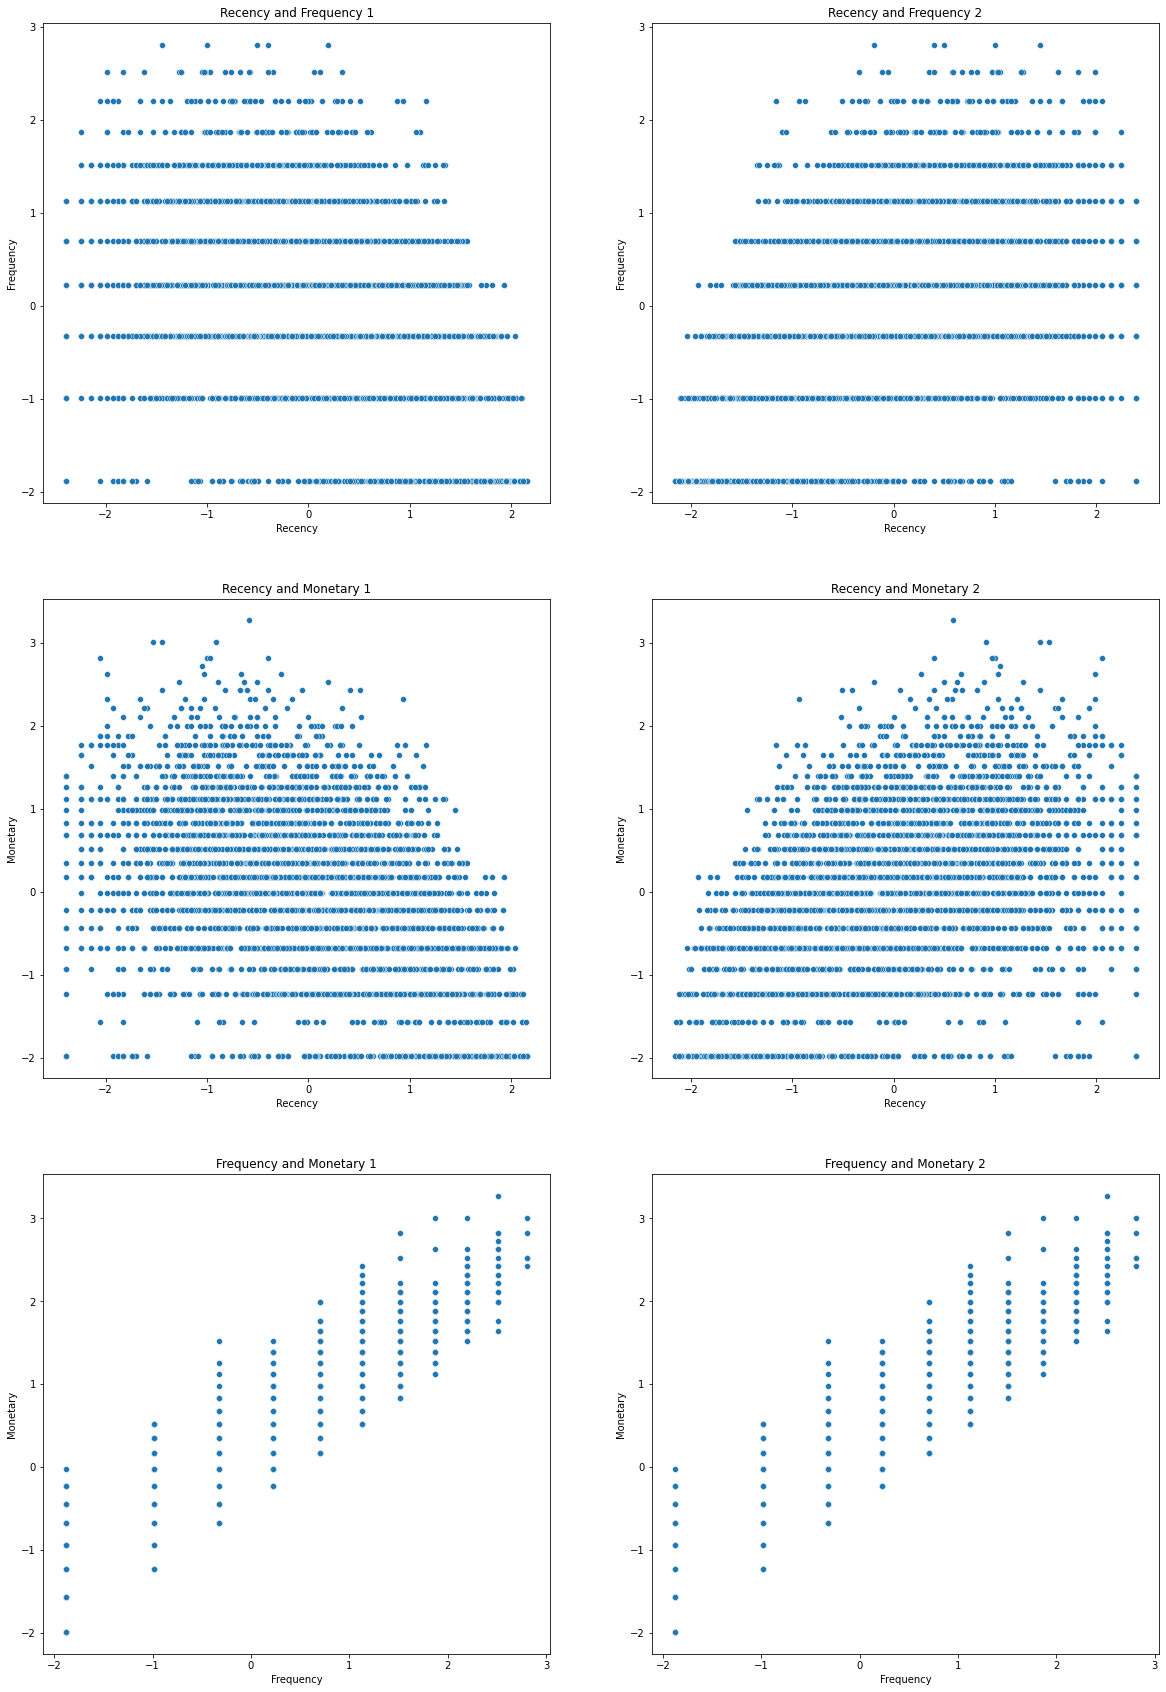

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(20,30))

sns.scatterplot(ax=ax[0,0], data=customers_RFM_Normalised_1, x='Recency', y='Frequency')
ax[0,0].set_title('Recency and Frequency 1')

sns.scatterplot(ax=ax[1,0], data=customers_RFM_Normalised_1, x='Recency', y='Monetary')
ax[1,0].set_title('Recency and Monetary 1')

sns.scatterplot(ax=ax[2,0], data=customers_RFM_Normalised_1, x='Frequency', y='Monetary')
ax[2,0].set_title('Frequency and Monetary 1')

sns.scatterplot(ax=ax[0,1], data=customers_RFM_Normalised_2, x='Recency', y='Frequency')
ax[0,1].set_title('Recency and Frequency 2')

sns.scatterplot(ax=ax[1,1], data=customers_RFM_Normalised_2, x='Recency', y='Monetary')
ax[1,1].set_title('Recency and Monetary 2')

sns.scatterplot(ax=ax[2,1], data=customers_RFM_Normalised_2, x='Frequency', y='Monetary')
ax[2,1].set_title('Frequency and Monetary 2')


In [35]:
# fig, ax = plt.subplots(3, 2, figsize=(20,20))
# ax[0,0] = plt.axes(projection = '3d')
# ax[0,0].scatter3D(customers_RFM_Normalised_1['Recency'], customers_RFM_Normalised_1['Frequency'], customers_RFM_Normalised_1['Monetary'])
# ax[0,0].ylabel = 'Y'

B:\Software\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
B:\Software\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
B:\Software\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
B:\Software\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
B:\Software\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: F

<AxesSubplot:xlabel='k', ylabel='silhouette Score'>

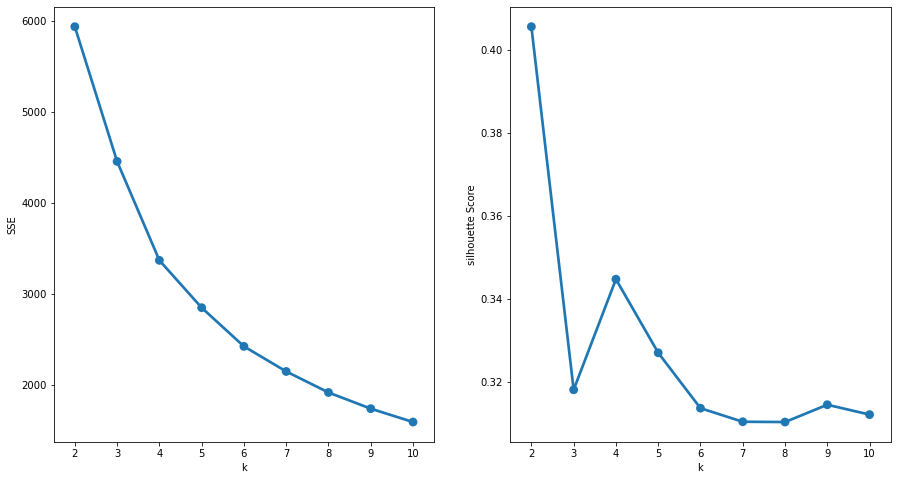

In [65]:
sse = {}
silhouetteScores = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=300)
    kmeans.fit(customers_RFM_Normalised_2)
    sse[k] = kmeans.inertia_ 
    silhouetteScores[k] = silhouette_score(customers_RFM_Normalised_2, kmeans.labels_)

plt.figure(figsize=(15, 8))
ax = plt.subplot(1, 2, 1)
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

ax = plt.subplot(1, 2, 2)
plt.xlabel('k')
plt.ylabel('silhouette Score')
sns.pointplot(x=list(sse.keys()), y=list(silhouetteScores.values()))


In [66]:
sseSlope = {}
temp = {}
sse

{2: 5939.6095721463735,
 3: 4456.265908048625,
 4: 3367.3512901540284,
 5: 2846.4165478949176,
 6: 2420.4246593136777,
 7: 2144.1732019455394,
 8: 1913.0312748590954,
 9: 1734.8303399622725,
 10: 1587.5818260745195}

In [67]:
for i in range(2,10):
    sseSlope[i] = sse[i+1] - sse[i]
    
for i in range(2,9):
    temp[i] = round(sseSlope[i+1] / sseSlope[i],1)
    
temp

{2: 0.7, 3: 0.5, 4: 0.8, 5: 0.6, 6: 0.8, 7: 0.8, 8: 0.8}

In [72]:
model = KMeans(n_clusters=4, random_state=300)
model.fit(customers_RFM_Normalised_2)
Customers_RFM_Clustered_2 = Customers_RFM_2.copy()
Customers_RFM_Clustered_2["Cluster"] = model.labels_
Customers_RFM_Clustered_2.groupby('Cluster').agg({
'Recency':'mean',
'Frequency':'mean',
'Monetary':['mean', 'count']})


B:\Software\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recency Frequency   Monetary      
             mean      mean       mean count
Cluster                                     
0        0.061044  3.325397   8.563492   882
1        0.004143  1.607101   3.895858   845
2        0.038413  6.231898  16.707436  1022
3        0.004376  3.744996   9.438642  1149

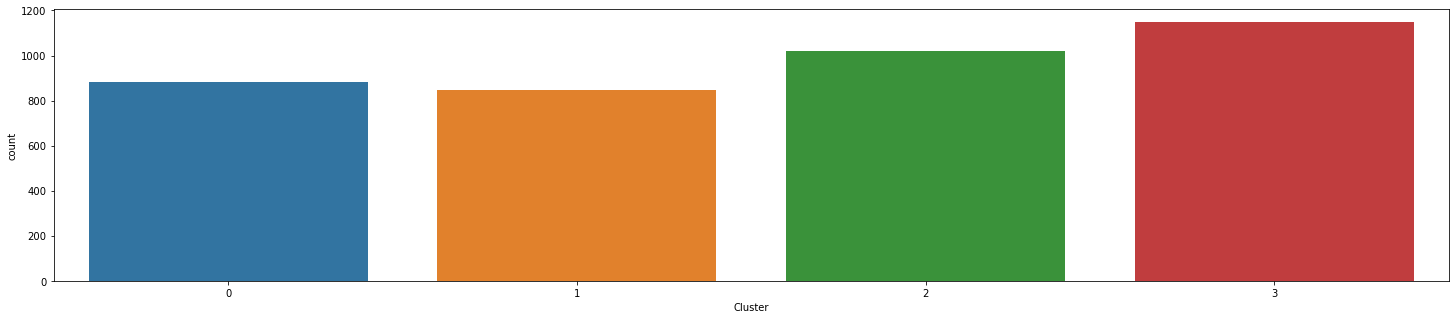

In [73]:
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Cluster", data=Customers_RFM_Clustered_2)

In [76]:
fig_data_normCust = pd.DataFrame(customers_RFM_Normalised_2, columns=['Recency', 'Frequency', 'Monetary'])
fig_data_normCust['ID'] = customers_RFM_Normalised_2.index
fig_data_normCust['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(fig_data_normCust.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','Monetary'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head(10)

,ID,Cluster,Attribute,Value
0,1000,2,Recency,1.083711
1,1001,3,Recency,-0.588682
2,1002,3,Recency,0.132977
3,1003,3,Recency,-0.946600
4,1004,2,Recency,1.214202
5,1005,1,Recency,-2.110171
6,1006,3,Recency,-0.365227
7,1008,0,Recency,0.422372
8,1009,0,Recency,0.441547
9,1010,3,Recency,-0.080704


B:\Software\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

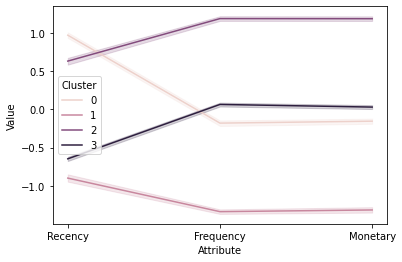

In [75]:
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

In [89]:
test = df([[1, 'Recency', -2], [1, 'Recency', 7], [1, 'a', 0], [2, 'Recency', -2], [2, 'a', 2]], columns=['Cluster', 'Attribute', 'Value'])

B:\Software\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

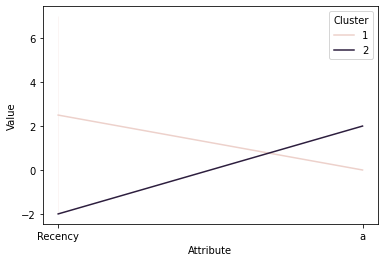

In [90]:
sns.lineplot('Attribute', 'Value', hue='Cluster', data=test)

<AxesSubplot:>

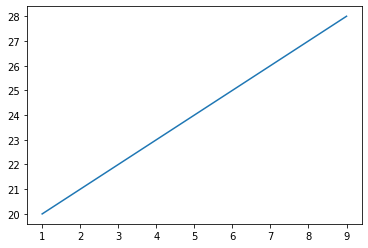

In [79]:
sns.lineplot(x=range(1,10), y= range(20,29))

In [30]:
if con:
        con.close()